In [16]:
import torch
import torch.nn as nn
import os
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms

In [17]:
class ChanelAttention(nn.Module):
    def __init__(self, in_c, ratio):
        super().__init__()
        hidden_c = max(in_c // ratio, 1)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.maxpool = nn.AdaptiveMaxPool2d(1)
        
        self.fc = nn.Sequential(
            nn.Conv2d(in_c, hidden_c, kernel_size=1, padding=0, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(hidden_c, in_c, kernel_size=1, padding=0, bias=False)
        )

        
    def forward(self, x):
        avg_x = self.fc(self.avgpool(x))
        max_x = self.fc(self.maxpool(x))
        out = avg_x + max_x
        return torch.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size=7, padding=3, bias=False)
        
    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        out = torch.cat([avg_out, max_out], dim=1)
        out = self.conv(out)
        return torch.sigmoid(out)

class CBAM(nn.Module):
    def __init__(self, in_c, ratio=8):
        super().__init__()
        self.CA = ChanelAttention(in_c, ratio)
        self.SA = SpatialAttention()
        
    def forward(self, x):
        x = x * self.CA(x)
        x = x * self.SA(x)
        return x

class ResidualCBAM(nn.Module):
    def __init__(self, in_c, ratio):
        super().__init__()
        hidden_c = max(in_c // ratio, 1)
        
        self.convdown = nn.Conv2d(in_c, hidden_c, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(hidden_c)
        
        self.conv3 = nn.Conv2d(hidden_c, hidden_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(hidden_c)
        
        self.convup = nn.Conv2d(hidden_c, in_c, kernel_size=1)
        self.bn3 = nn.BatchNorm2d(in_c)
        
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(0.3)
        self.cbam = CBAM(in_c, ratio=8)
        
    def forward(self, x):
        shortcut = x
        x = self.convdown(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv3(x)
        x = self.bn2(x)
        x = self.relu(x)
        
        x = self.convup(x)
        x = self.bn3(x)
        x = self.dropout(x)
        
        x = self.cbam(x)
        x = x + shortcut
        return torch.relu(x)


In [18]:
class Coordinate(nn.Module):
    def __init__(self, in_ch):
        super().__init__()
        mid_ch = max(8, in_ch // 2)

        self.h_pool = nn.AdaptiveAvgPool2d((1, None))
        self.h_conv = nn.Conv2d(in_ch, mid_ch, kernel_size=(1, 3), padding=(0, 1), bias=False)

        self.v_pool = nn.AdaptiveAvgPool2d((None, 1))
        self.v_conv = nn.Conv2d(in_ch, mid_ch, kernel_size=(3, 1), padding=(1, 0), bias=False)

        self.fuse = nn.Conv2d(mid_ch * 2, in_ch, kernel_size=1, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        shortcut = x
        h = self.h_conv(self.h_pool(x))
        v = self.v_conv(self.v_pool(x))

        h = nn.functional.interpolate(h, size=x.shape[2:], mode='bilinear', align_corners=False)
        v = nn.functional.interpolate(v, size=x.shape[2:], mode='bilinear', align_corners=False)

        att = torch.cat([h, v], dim=1) 
        att = self.fuse(att)            
        att = self.sigmoid(att)
        return x * att

In [19]:
class ResCBAMCoordAtt(nn.Module):
    def __init__(self, in_c, ratio):
        super().__init__()
        self.rescbam = ResidualCBAM(in_c, ratio)
        self.coordatt = Coordinate(in_c)
    
    def forward(self, x):
        x = self.rescbam(x)
        out = self.coordatt(x)
        return out

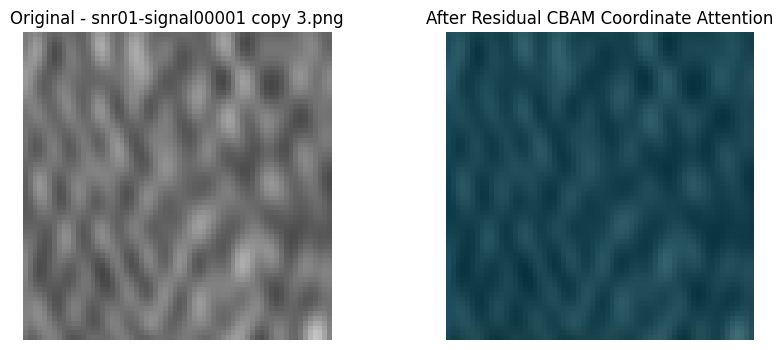

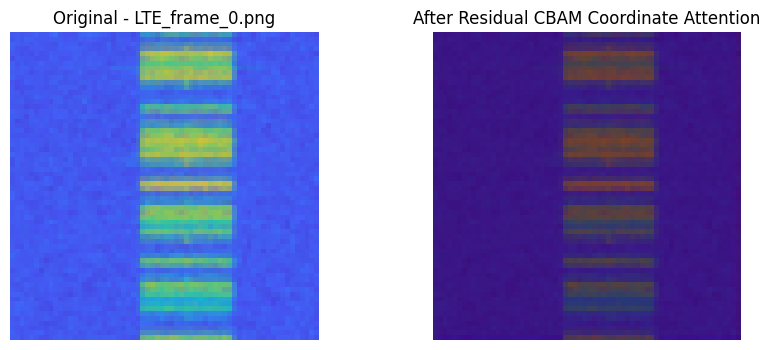

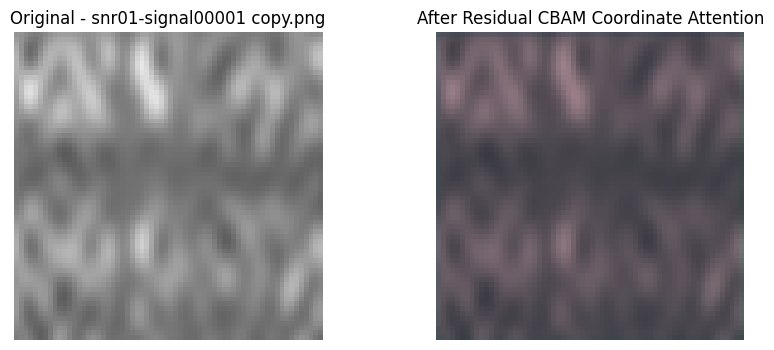

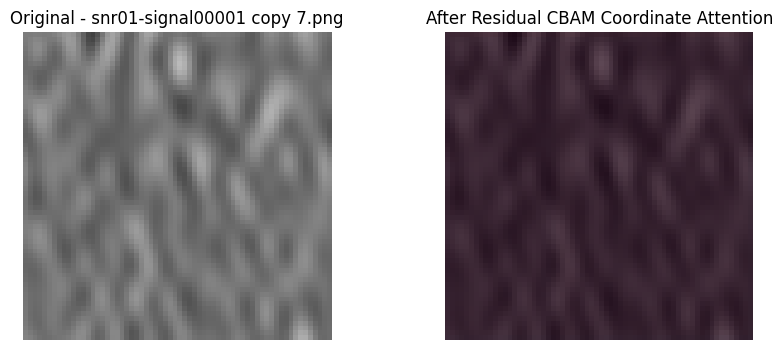

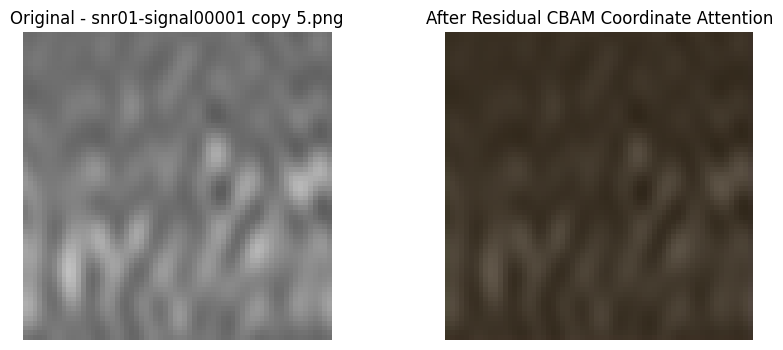

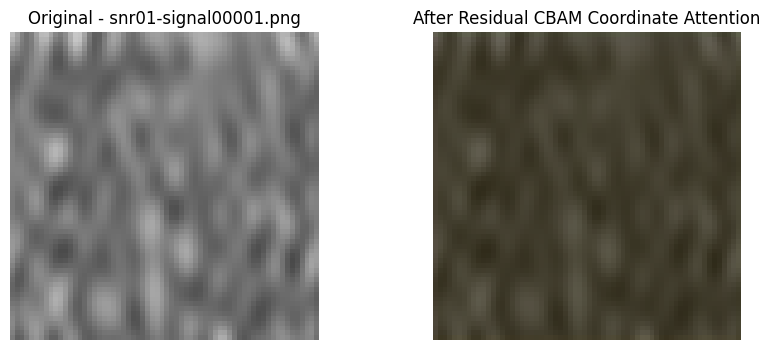

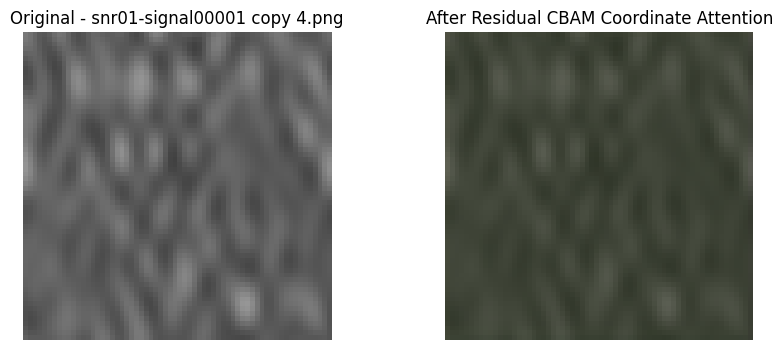

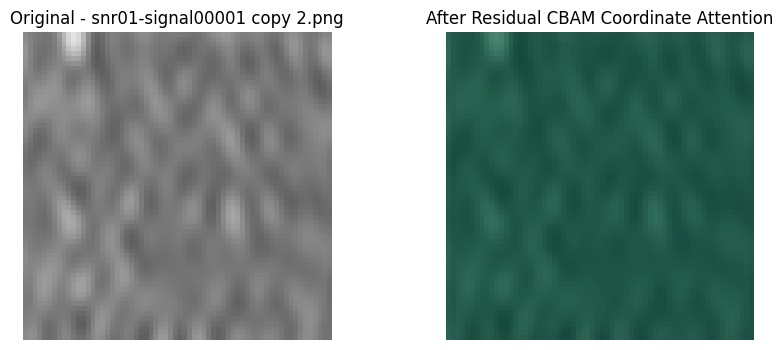

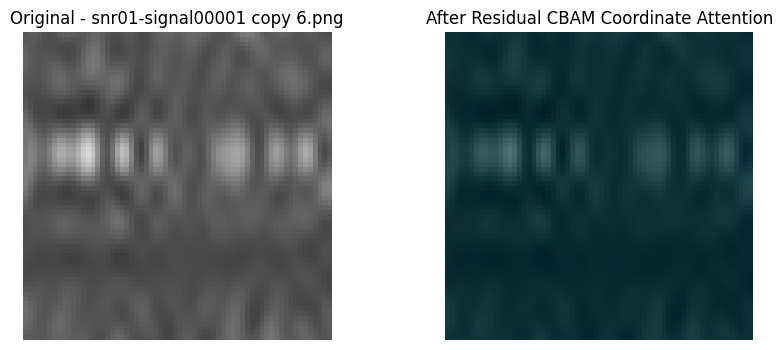

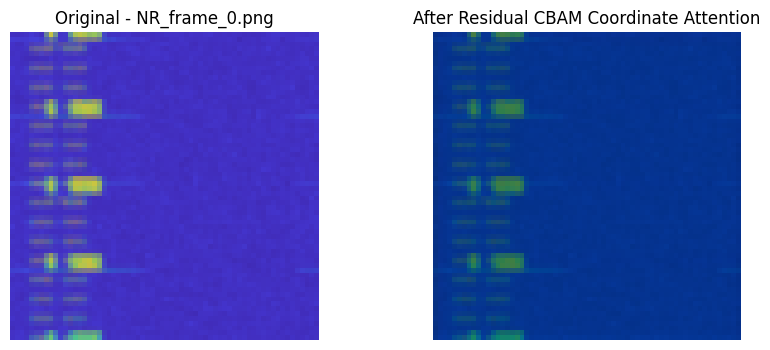

In [20]:
img_folder = '/home/vydat/Code/ML_AI/Source/img'

for img_name in os.listdir(img_folder):
    img_path = os.path.join(img_folder, img_name)
    
    if img_path.endswith(('.png', '.jpg', '.jpeg')): 
        image = Image.open(img_path).convert('RGB')

        transform = transforms.Compose([
            transforms.Resize((64, 64)),
            transforms.ToTensor()
        ])

        img_tensor = transform(image).unsqueeze(0)

        model = ResCBAMCoordAtt(3, 8)
        model.eval()

        with torch.no_grad():
            out_tensor = model(img_tensor).squeeze().clamp(0, 1)

        def tensor_to_image(tensor):
            return tensor.permute(1, 2, 0).cpu().numpy()

        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.title(f'Original - {img_name}')
        plt.imshow(tensor_to_image(img_tensor.squeeze()))
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.title(f'After Residual CBAM Coordinate Attention')
        plt.imshow(tensor_to_image(out_tensor))
        plt.axis('off')

        plt.show()